# <center> Статистические тесты в контексте EDA. 
## <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Бизнес проблема.

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа мы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

- Если мы найдём в данных интересные закономерности, также отметьтим их в своём анализе.

Продемонстрируем использование разных тестов для проверки статистической значимости сделанных выводов:

- тесты для количественного признака:
    - для одной выборки;
    - для двух выборок;
    - для нескольких выборок;
- тест для категориальных признаков.

Мы будем использовать уровень значимости $\alpha$ - порог для оценки результата как статистически значимого. Если показатель значимости будет ниже уровня значимости, результат будет считается статистически значимым. 

__На каждый вопрос мы будем отвечать с уровнем значимости $\alpha=0.05$.__

Это значит, что вероятность случайного получения статистически значимого результата составляет менее 5% - т.е мы готовы в 5% допустить ошибку 1 рода - сделать вывод, что эффект есть, хотя на самом деле его нет.

Ошибка 1 рода - вероятность отклонить нулевую гипотезу, когда она верна.
***

У нас есть датасет с данными о зарплате в сфере Data Science за 2020–2022 годы. Датасет содержит следующие столбцы-параметры.

- work_year - Год, в котором была выплачена зарплата.
- experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
- employment_type - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- job_title - Роль, в которой соискатель работал в течение года.
- salary - Общая выплаченная валовая сумма заработной платы.
- salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
- salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
- employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
- remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
- company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
- company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

### Imports
Import libraries and write settings.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels import stats as sms


# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set aspects of the visual theme
sns.set_theme("notebook") # установка предварительных настроек маштабирования
sns.set_palette("husl") # установка предварительной световой палитры

In [2]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


# Analysis/Modeling

### Исследование структуры данных.

In [3]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.zip')
display(data)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [4]:
# Посмотрим размерность данных
display(data.shape)

(607, 12)

In [5]:
# Оценим информацию о датафрейме
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None

In [6]:
# Посмотрим статистическую информацию по всем столбцам
display(data.describe(include = 'all'))

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607.000000,607,607,607,6.070000e+02,607,607.000000,607,607.00000,607,607
unique,NaN,NaN,4,4,50,NaN,17,NaN,57,NaN,50,3
top,NaN,NaN,SE,FT,Data Scientist,NaN,USD,NaN,US,NaN,US,M
freq,NaN,NaN,280,588,143,NaN,398,NaN,332,NaN,355,326
mean,303.000000,2021.405272,NaN,NaN,NaN,3.240001e+05,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,175.370085,0.692133,NaN,NaN,NaN,1.544357e+06,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,0.000000,2020.000000,NaN,NaN,NaN,4.000000e+03,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,151.500000,2021.000000,NaN,NaN,NaN,7.000000e+04,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,303.000000,2022.000000,NaN,NaN,NaN,1.150000e+05,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,454.500000,2022.000000,NaN,NaN,NaN,1.650000e+05,NaN,150000.000000,NaN,100.00000,NaN,NaN


In [7]:
# Поищем дубликаты. Предварительно создадим список столбцов dupl_columns, по которым 
# будем искать совпадения (все столбцы, не включая Unnamed: 0, т.к. он задает каждой 
# строке свой уникальный индентификатор). 
dupl_columns = list(data.columns)
dupl_columns.remove('Unnamed: 0')
# Создадим маску дубликатов с помощью метода duplicated() и произведём фильтрацию. 
# Результат заносим в переменную data_duplicates. Выведем число строк.
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 42


In [8]:
# Посмотрим пропуски
display(data.isnull().sum())

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

<hr style="border-style: dashed;">

У нас есть датасет со следующими данными:   
- размерность 607 строк и 12 параметров (столбцов)
- 5 параметров числовых: Unnamed: 0, work_year, salary, salary_in_usd, remote_ratio
- 7 категориальных: experience_level, employment_type, job_title, salary_currency, employee_residence, company_location, company_size
- в датасете 42 дубликата
- пропусков у нас нет

__Вывод__:  
Нам надо будет удалить параметр - 'Unnamed: 0', так как он не представляет для нас ценности и представляет из себя идентификатор строк датафрейма. Также надо удалить 42 найденных дубликата. Возможно нам надо будет перекодировать категориальные данные при более близком знакомстве с ними. При более близком знакомстве с параметрами возможно, еще что то удалим (кандидаты - salary, salary_currency) 
<hr style="border-style: dashed;">

In [9]:
# Удаляем дубликаты и параметр.
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop_duplicates()
print('Размер таблицы после удаления: {}'.format(data.shape))

Размер таблицы после удаления: (565, 11)


# <center> Проведем одномерный анализ данных

Мы исследуем каждый столбец и посмотрим распределение данных и другую информацию которую сможем найти. 
Сначала исследуем числовые данные, затем категориальнные.
    
## <center> Числовые данные

- work_year
- salary 
- salary_in_usd
- remote_ratio

    
###  <center> Распределение зарплаты DS (salary_in_usd)
    
Так как нам надо сравнивать данные с зарплатой, то изучим общее распределение зарплат DS, как они располагаються с точки зрения наблюдений. Изучать мы будем столбец - salary_in_usd, так как здесь зарплата приведенна к обшему знаменателю.
Так как, мы хотим посмотреть распределение числового признака, то воспользуемся гистограммой.

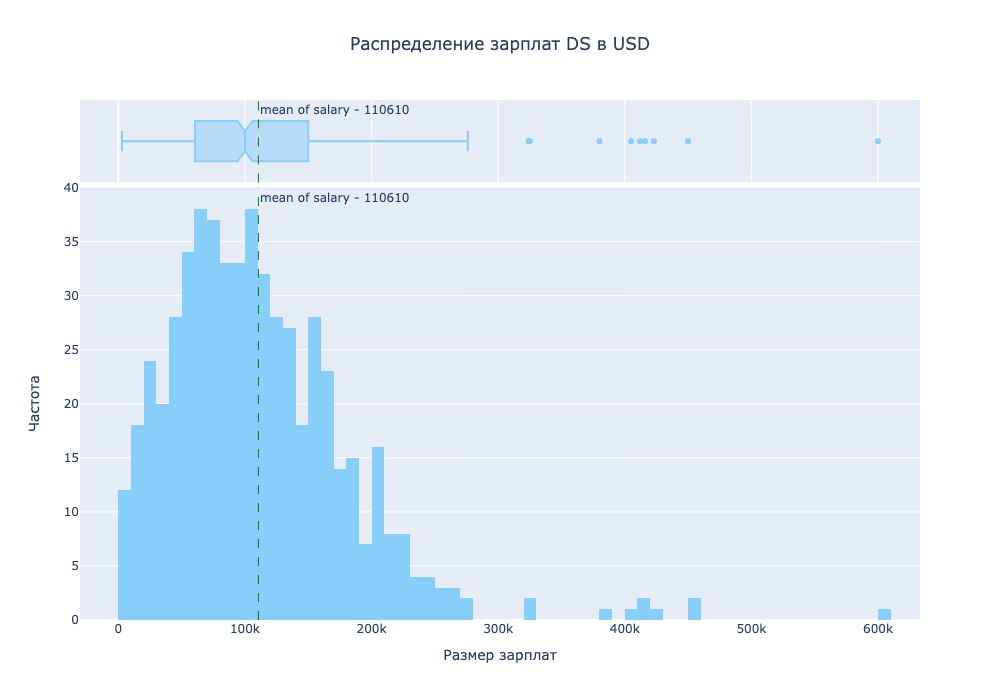

In [54]:
# Так как у нас зарплаты выплачиваються в разных валютах, у нас есть параметр который
# приводит все зарплаты в долларах - воспользуемся им.
fig = px.histogram(data, 
                    nbins=100,
                    x="salary_in_usd",
                    title="Распределение зарплат DS в USD",
                    width = 1000, 
                    height = 700, 
                    color_discrete_sequence=["lightskyblue"],
                    marginal='box',
                )

# Нарисуем линию среднего salary_in_usd
fig.add_vline(x=data['salary_in_usd'].mean(), 
              line_width=1,
              line_dash="dash", 
              annotation_text = 'mean of salary - 110610', 
              line_color="green")

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Размер зарплат", 
                    yaxis_title="Частота",
                 )


fig.show('jpeg')
#fig.write_html("data/plotly/001_scheduling_salary_histogram.html")

In [50]:
# Посмотрим числовые характеристики
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат в USD']
data_agg

,Размер зарплат в USD
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


<hr style="border-style: dashed;">

__Вывод:__
- Распределение у нас ненормальное как видно по графику, не совпадает медианна (100 тысяч) и среднее (среднее - пунктирная зеленая линия 110610)  
- Крайние значения: слева - 2859, справа - 600 тысяч.
- Присутствуют выбросы

<hr style="border-style: dashed;">

#### Год, в котором была выплачена зарплата (work_year).

In [44]:
# Посмотрим признак
salary_year = data['work_year'].value_counts()
display(salary_year)

2022    278
2021    215
2020     72
Name: work_year, dtype: int64

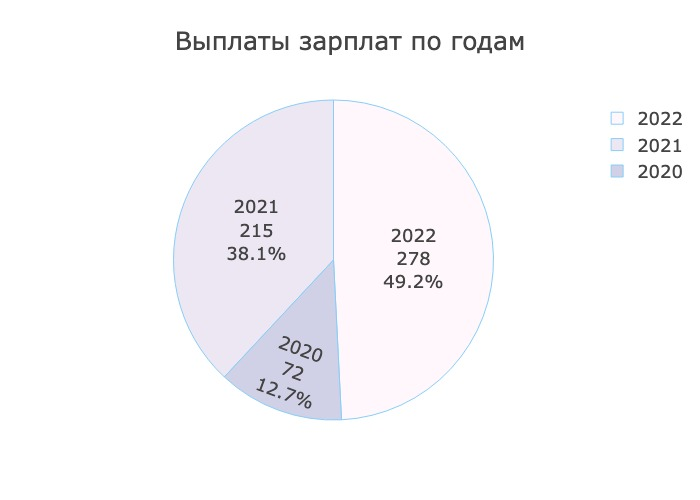

In [48]:
# Посмотрим пропорцию годов - выберем круговую диаграмму 
fig = px.pie(values=salary_year.values, 
             names=salary_year.index, 
             color_discrete_sequence=px.colors.sequential.PuBu,
             title= 'Выплаты зарплат по годам',
             template='presentation'
            )

fig.update_traces(textinfo='label+percent+value', 
                  textfont_size=18,
                  marker=dict(line=dict(color='lightskyblue', width=1)))


fig.show('jpeg')
#fig.write_html("data/plotly/002_salary_year_pie.html")

<hr style="border-style: dashed;">

__Вывод:__   
Как видим около половины у нас занимает 2022 год, затем идет 2021 и замыкает 2020.

Могу предположить, что с 2020 года начался рост популярности профессий DS и начали массов набирать специалистов.
<hr style="border-style: dashed;">

#### Общая выплаченная валовая сумма заработной платы (salary)    
Данный столбец у нас также отражает зарплату, но здесь есть нюанс, он отражает зарплату в разных валютах. А валюты у нас храняться в категориальном столбце (salary_currency). 

In [51]:
# Посмотрим числовые характеристики
data_agg = data['salary'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат']
data_agg

,Размер зарплат
count,565.00
mean,338115.99
std,1599878.79
min,4000.00
25%,67000.00
50%,110925.00
75%,165000.00
max,30400000.00


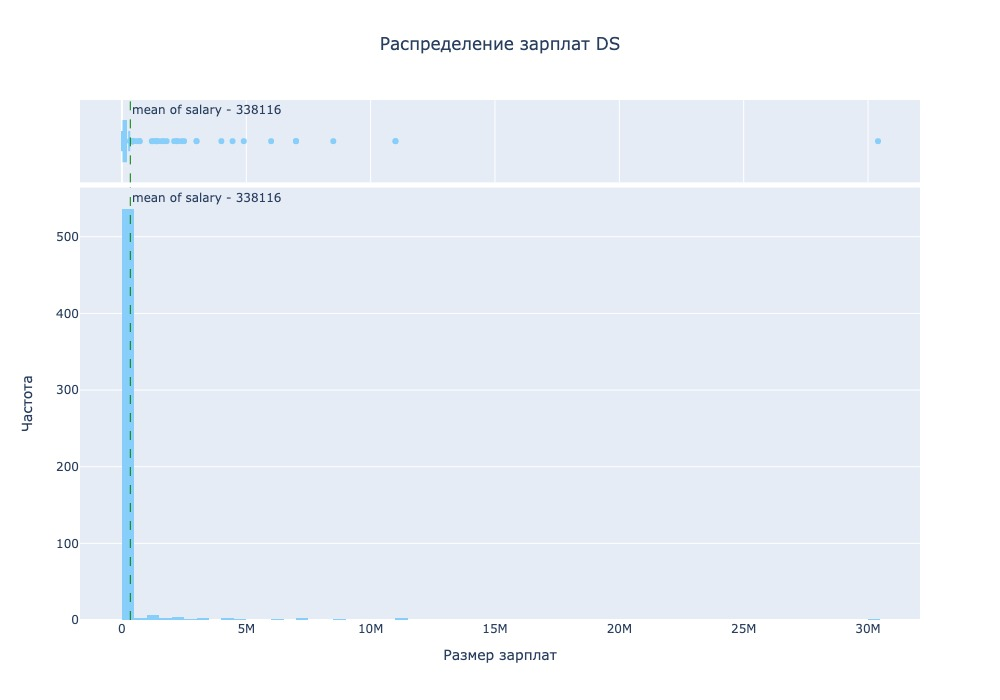

In [56]:
# Посмотрим распределение числового признака - выебрем гистограмму
fig = px.histogram(data, 
                    nbins=100,
                    x="salary",
                    title="Распределение зарплат DS",
                    width = 1000, 
                    height = 700, 
                    color_discrete_sequence=["lightskyblue"],
                    marginal='box',
                )

# Нарисуем линию среднего salary_in_usd
fig.add_vline(x=data['salary'].mean(), line_width=1, line_dash="dash", 
              annotation_text = 'mean of salary - 338116', 
              line_color="green")

# Обновим данные для осей и названия
fig.update_layout(title_x = 0.5,
                    xaxis_title="Размер зарплат", 
                    yaxis_title="Частота",
                 )


fig.show('jpeg')
#fig.write_html("data/plotly/003_scheduling_salary_histogram.html")

__Вывод:__   
- Как мы видим распределение не нормальное, медианна (110.9 тысяч) не совпадает со средним (338.1 тысяч)
- Крайние значения: слева - 4000, справа - 30.4 миллиона

Скорее всего данный столбец мы удалим.

338116.0

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here